In [10]:
# import Modules
import numpy as np
from stl import mesh
import matplotlib.pyplot as plt

%matplotlib widget

In [11]:
# import stl file
Benchy_mesh = mesh.Mesh.from_file('3DBenchy.stl')
print("File loaded in as faces and vertices")

exception (False, "b'\\xd7\\xd3@\\x00\\x00\\xa0\\xbf\\xdfo\\x9da\\x00\\x00\\xf95\\x7f\\xbf\\x0b\\xd5\\xc1&*\\xaf\\xa0=\\xa0\\x1a\\xd3@\\xbe\\x9f\\x9a\\xbf\\xc3\\xf5\\x9aa)\\\\\\xd3@\\xa4p\\x9d\\xbfj\\xbc\\x9bam\\xe7\\xd3@\\x00\\x00\\x00\\x00\\x12\\x83\\x9da\\x00\\x00\\xf95\\x7f\\xbf\\x86\\xaa\\xa9\\xa6*\\xaf\\xa0=)\\\\\\xd3@\\xa4p\\x9d\\xbfj\\xbc\\x9ba\\x81\\x95\\xd3@d;\\x9f\\xbf\\x1f\\x85\\x9cam\\xe7\\xd3@\\x00\\x00\\x00\\x00\\x12\\x83\\x9da\\x00\\x00\\xf95\\x7f\\xbf\\x1b\\x82\\x80%*\\xaf\\xa0=m\\xe7\\xd3@\\x00\\x00\\x00\\x00\\x12\\x83\\x9da\\x81\\x95\\xd3@d;\\x9f\\xbf\\x1f\\x85\\x9ca' should start with b'facet normal'")
File loaded in as faces and vertices


In [12]:
# Slice STL file at each z value and return a 
# pair of points that 

def STL_Slicer(stl_mesh,layers):
    # initilize points
    Set_1 = np.zeros([3,0])
    Set_2 = np.zeros([3,0])

    # save faces that dont would through error
    Bad_Faces = np.array([])

    l = len(stl_mesh.vectors[:])
    #l = 50000*2
    for face in range(l):
        # check if face is actually a line (bad stl file)
        v1 = stl_mesh.vectors[face][0,:] - stl_mesh.vectors[face][1,:]
        v2 = stl_mesh.vectors[face][1,:] - stl_mesh.vectors[face][2,:] 
        v3 = stl_mesh.vectors[face][2,:] - stl_mesh.vectors[face][0,:]
        # check that face intercept z point
        z_lim = np.array([stl_mesh.vectors[face][:,2].min(),stl_mesh.vectors[face][:,2].max()])
        inter = (z_lim[0]-layers)*(z_lim[1]-layers) < 0
        
        if np.any(np.all(v1==0) or np.all(v2==0) or np.all(v3==0) or np.all(inter)):
            Bad_Faces = np.append(Bad_Faces,face) # for debugging
            # just compute random task
        else:
            
            # code used to find slice lines
            t = np.zeros([3]) # initilaize line parameter

            ## solve for all z intercepts
            idx = np.where((layers>z_lim[0]) & (layers<z_lim[1]))[0]

            # solve line intercept parameter value
            t = np.zeros([3,len(idx)])

            t[0,:] = np.transpose((layers[idx]-stl_mesh.vectors[face][0,2])/(stl_mesh.vectors[face][1,2]-stl_mesh.vectors[face][0,2]))
            t[1,:] = np.transpose((layers[idx]-stl_mesh.vectors[face][1,2])/(stl_mesh.vectors[face][2,2]-stl_mesh.vectors[face][1,2]))
            t[2,:] = np.transpose((layers[idx]-stl_mesh.vectors[face][2,2])/(stl_mesh.vectors[face][0,2]-stl_mesh.vectors[face][2,2]))

            II0 = np.array((stl_mesh.vectors[face][1,:]-stl_mesh.vectors[face][0,:]).reshape(-1,1)*t[0,:] + stl_mesh.vectors[face][0,:].reshape(-1,1))
            II1 = np.array((stl_mesh.vectors[face][2,:]-stl_mesh.vectors[face][1,:]).reshape(-1,1)*t[1,:] + stl_mesh.vectors[face][1,:].reshape(-1,1))
            II2 = np.array((stl_mesh.vectors[face][0,:]-stl_mesh.vectors[face][2,:]).reshape(-1,1)*t[2,:] + stl_mesh.vectors[face][2,:].reshape(-1,1))

            # remove points outside of bounds
            idx0 = ((II0[0,:]<stl_mesh.vectors[face][[0,1],0].min()) + (II0[0,:]>stl_mesh.vectors[face][[0,1],0].max()) 
                + (II0[1,:]<stl_mesh.vectors[face][[0,1],1].min()) + (II0[1,:]>stl_mesh.vectors[face][[0,1],1].max())
                + (II0[2,:]<stl_mesh.vectors[face][[0,1],2].min()) + (II0[2,:]>stl_mesh.vectors[face][[0,1],2].max()))
            idx1 = ((II1[0,:]<stl_mesh.vectors[face][[1,2],0].min()) + (II1[0,:]>stl_mesh.vectors[face][[1,2],0].max()) 
                + (II1[1,:]<stl_mesh.vectors[face][[1,2],1].min()) + (II1[1,:]>stl_mesh.vectors[face][[1,2],1].max())
                + (II1[2,:]<stl_mesh.vectors[face][[1,2],2].min()) + (II1[2,:]>stl_mesh.vectors[face][[1,2],2].max()))
            idx2 = ((II2[0,:]<stl_mesh.vectors[face][[0,2],0].min()) + (II2[0,:]>stl_mesh.vectors[face][[0,2],0].max()) 
                + (II2[1,:]<stl_mesh.vectors[face][[0,2],1].min()) + (II2[1,:]>stl_mesh.vectors[face][[0,2],1].max())
                + (II2[2,:]<stl_mesh.vectors[face][[0,2],2].min()) + (II2[2,:]>stl_mesh.vectors[face][[0,2],2].max()))
            
            # save points for every intercept for every z level...
            II0[:,idx0] = 0
            II1[:,idx1] = 0
            II2[:,idx2] = 0

            # combine points into pairs of points that can be stored easily
            # find the ONE line that has all points within bonds. This is the base line
            # the secondary points are the sum of the other two points becuase index above 
            # sets outof bounds points to zero
            if(sum(idx0)==0):
                    P1 = II0
                    P2 = II1 + II2
            elif(sum(idx1)==0):
                    P1 = II1
                    P2 = II0 + II2
            else:
                    P1 = II2
                    P2 = II0 + II1
            
            Set_1 = np.append(Set_1,P1,axis=1)
            Set_2 = np.append(Set_2,P2,axis=1)

    print("Num of Bad Faces: ",len(Bad_Faces)," Total Num of Faces: ",len(stl_mesh.vectors[:]))
    return Set_1, Set_2

# run slicer
z = np.linspace(0,30,150) # z slices
p1, p2 = STL_Slicer(Benchy_mesh,z)

C:\Users\kaden\AppData\Local\Temp/ipykernel_6424/3633929894.py:39: RuntimeWarning: divide by zero encountered in true_divide
  t[2,:] = np.transpose((layers[idx]-stl_mesh.vectors[face][2,2])/(stl_mesh.vectors[face][0,2]-stl_mesh.vectors[face][2,2]))
C:\Users\kaden\AppData\Local\Temp/ipykernel_6424/3633929894.py:43: RuntimeWarning: invalid value encountered in multiply
  II2 = np.array((stl_mesh.vectors[face][0,:]-stl_mesh.vectors[face][2,:]).reshape(-1,1)*t[2,:] + stl_mesh.vectors[face][2,:].reshape(-1,1))
C:\Users\kaden\AppData\Local\Temp/ipykernel_6424/3633929894.py:37: RuntimeWarning: divide by zero encountered in true_divide
  t[0,:] = np.transpose((layers[idx]-stl_mesh.vectors[face][0,2])/(stl_mesh.vectors[face][1,2]-stl_mesh.vectors[face][0,2]))
C:\Users\kaden\AppData\Local\Temp/ipykernel_6424/3633929894.py:41: RuntimeWarning: invalid value encountered in multiply
  II0 = np.array((stl_mesh.vectors[face][1,:]-stl_mesh.vectors[face][0,:]).reshape(-1,1)*t[0,:] + stl_mesh.vectors[fa

Num of Bad Faces:  552  Total Num of Faces:  225706


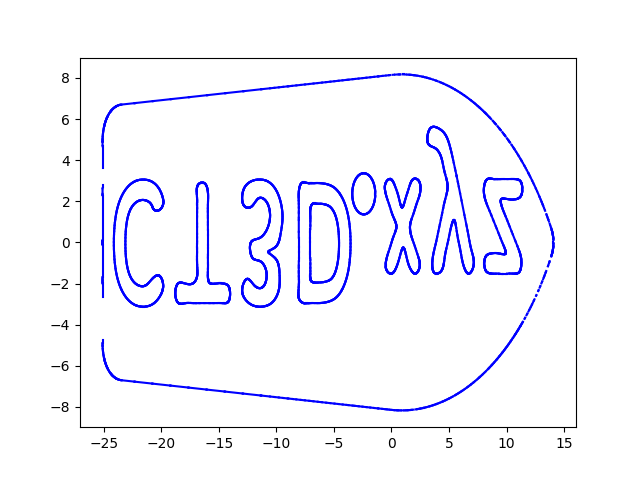

In [13]:
# Function used to plot layer of point
def Plot_Slice(P1,P2):
    X1 = P1[0]
    X2 = P2[0]
    Y1 = P1[1]
    Y2 = P2[1]
    plt.plot([X1,X2],[Y1,Y2],'b')

# select layer 100 and plot points
i = p1[2,:] ==z[1]
p1_100 = p1[0:2,i].copy()
p2_100 = p2[0:2,i].copy()

plt.close()
Plot_Slice(p1_100,p2_100)
plt.show()

In [14]:
# Generate Rays that can penetrate slice
def Generate_Rays(Theta,Spacing,Num):
    # iterction math: https://www.cuemath.com/geometry/intersection-of-two-lines/
    Rays = np.zeros([3,Num]) # empty matrix with a,b and c values ax+by+c=0
    if (Theta == 0): #horizontal lines
        print("horizontal")
        Rays[0,:] = 0
        Rays[1,:] = 1
        Rays[2,:] = np.arange(0, Spacing*Num,Spacing) - Num*Spacing/2 + Spacing/2
    elif (Theta == np.pi/2): # vertical lines
        print("Vertical")
        Rays[0,:] = 1
        Rays[1,:] = 0
        Rays[2,:] = np.arange(0, Spacing*Num,Spacing) - Num*Spacing/2 + Spacing/2
    else:
        print("angle")
        Rays[0,:] = -np.tan(Theta)
        Rays[1,:] = 1
        Rays[2,:] = (np.arange(0, Spacing*Num,Spacing) - Num*Spacing/2 + Spacing/2)/np.abs(np.cos(Theta))
    
    return Rays

rays = Generate_Rays(0*np.pi/180,1.5,10)

horizontal


angle
Done Test


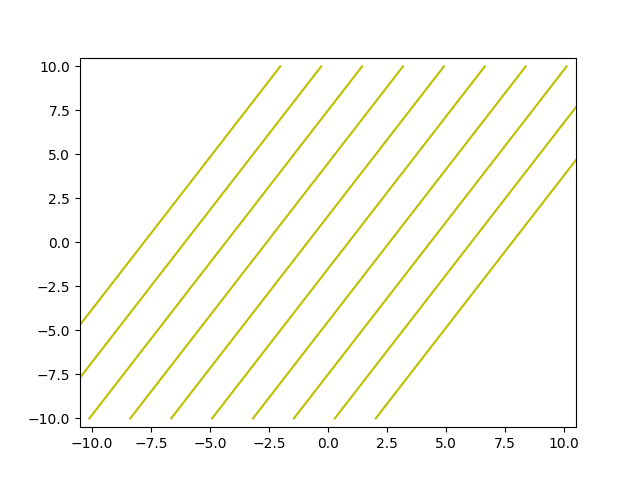

In [15]:
# plot Rays with a limiting box
def Plot_Rays(Rays,X_lim,Y_lim,color='y'):
    # takes ray parameters, x limit, and
    # y limit and plots the lines
    Y = np.zeros([2,len(Rays[0,:])])
    X = np.zeros([2,len(Rays[0,:])])

    M = -Rays[0,:]/Rays[1,:] # slope of lines
    idx_vert = (M >= 1) | (M < -1) # rays between 45-135 deg
    idx_line = idx_vert == 0 # all other rays

    # generate lines
    Y[0,idx_vert] += Y_lim[0]
    Y[1,idx_vert] += Y_lim[1]
    X[0,idx_vert] = -(Rays[1,idx_vert]*Y[0,idx_vert]+Rays[2,idx_vert])/Rays[0,idx_vert]
    X[1,idx_vert] = -(Rays[1,idx_vert]*Y[1,idx_vert]+Rays[2,idx_vert])/Rays[0,idx_vert]

    # generate lines
    X[0,idx_line] += X_lim[0]
    X[1,idx_line] += X_lim[1]
    Y[0,idx_line] = -(Rays[0,idx_line]*X[0,idx_line]+Rays[2,idx_line])/Rays[1,idx_line]
    Y[1,idx_line] = -(Rays[0,idx_line]*X[1,idx_line]+Rays[2,idx_line])/Rays[1,idx_line]

    # plot lines
    plt.plot(X,Y,color)
    plt.xlim(X_lim[0]*1.05,X_lim[1]*1.05)
    plt.ylim(Y_lim[0]*1.05,Y_lim[1]*1.05)
    return X,Y


# plot rays generated
x_lim = np.array([-10,10])
y_lim = np.array([-10,10])

plt.close()
Plot_Rays(Generate_Rays(60*np.pi/180,1.5,10),x_lim,y_lim) 
print("Done Test")

angle
test complete


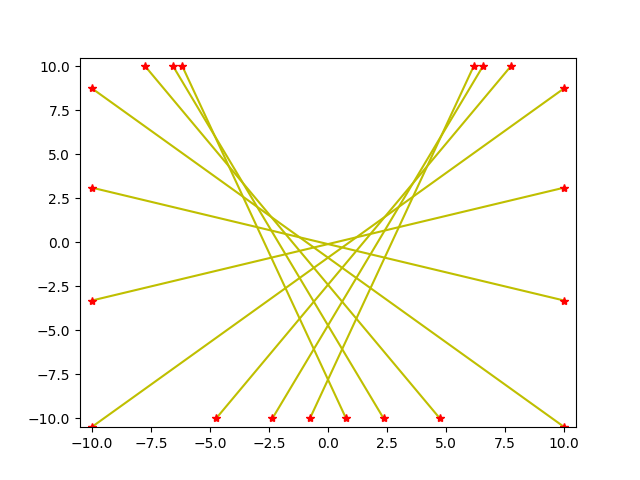

In [16]:
 # Generate Lines from 2 sets of points
def Generator_Lines(P1,P2):
    # takes to points P = [[x],[y]]
    # returns vector of a,b,c for line
    # ax+by+c=0
    A =-(P2[1] - P1[1])
    B = P2[0] - P1[0]
    C = -P1[0]*A - P1[1]*B
    return np.array([A,B,C])

plt.close()
testRays = Generate_Rays(30*np.pi/180,1.5,10) # generate lines
# scramble rays to test veriety
testRays[0,:] = testRays[0,:]*np.linspace(-5,5,len(testRays[0,:]))
testRays[2,:] = testRays[2,:]*np.linspace(-1,1,len(testRays[0,:]))
testPoint1, testPoint2 = Plot_Rays(testRays,x_lim,y_lim) # generate points from ray plotter
lines = Generator_Lines(testPoint1, testPoint2) # generate lines (should go back to rays)
Plot_Rays(testRays,x_lim,y_lim,'*r')
print("test complete")

horizontal


C:\Users\kaden\AppData\Local\Temp/ipykernel_6424/4068079722.py:6: RuntimeWarning: divide by zero encountered in true_divide
  X = (np.outer(Line1[1],Line2[2])-np.outer(Line1[2],Line2[1]))/(np.outer(Line1[0],Line2[1])-np.outer(Line1[1],Line2[0]))
C:\Users\kaden\AppData\Local\Temp/ipykernel_6424/4068079722.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y = (np.outer(Line1[2],Line2[0])-np.outer(Line1[0],Line2[2]))/(np.outer(Line1[0],Line2[1])-np.outer(Line1[1],Line2[0]))


 ...]

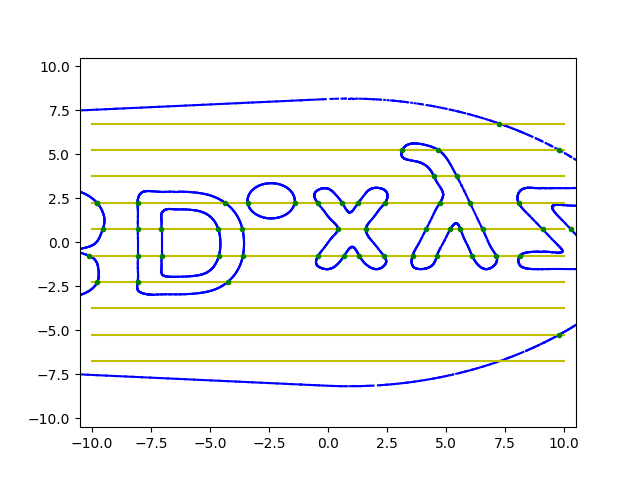

In [17]:
# find intercetion points between rays and slice
def Line_Intersection(Line1,Line2):
    # takes P = [[a],[b],[c]] where ax+by+C=0
    # returns points of intersection [x,y]
    # for all possible line combose
    X = (np.outer(Line1[1],Line2[2])-np.outer(Line1[2],Line2[1]))/(np.outer(Line1[0],Line2[1])-np.outer(Line1[1],Line2[0]))
    Y = (np.outer(Line1[2],Line2[0])-np.outer(Line1[0],Line2[2]))/(np.outer(Line1[0],Line2[1])-np.outer(Line1[1],Line2[0]))
    return X,Y

# filter out data points that dont lie inbtween p1 p2
def In_Bound_Points(X_in, Y_in, P1, P2):
    # takes points of intersection of lines and
    # points of lines. replaces all points not 
    # inbetween P1, P2 returns x,y
    X = X_in.copy()
    Y = Y_in.copy()
    X_max = np.max([P1[0],P2[0]],axis=0)
    X_min = np.min([P1[0],P2[0]],axis=0)
    Y_max = np.max([P1[1],P2[1]],axis=0)
    Y_min = np.min([P1[1],P2[1]],axis=0)
    idx = ((X<X_min) | (X>X_max)) | ((Y<Y_min) | (Y>Y_max))

    X[idx] = np.NaN
    Y[idx] = np.NaN
    return X,Y

lines = Generator_Lines(p1_100,p2_100) # generate lines from slice 100

rays = Generate_Rays(0*np.pi/180,1.5,10) # Generate rays

xp,yp = Line_Intersection(rays,lines) # Calculate intersection matriz reutrn x y points

xpf,ypf = In_Bound_Points(xp,yp,p1_100,p2_100) # filter out points that dont lie inbtween points

# plot results
# fit around outline
plt.close()
Plot_Slice(p1_100,p2_100)
Plot_Rays(rays,x_lim,y_lim)
x_lim = np.array([np.min(p1_100[0,:]),np.max(p1_100[0,:])])*1.05
y_lim = np.array([np.min(p1_100[1,:]),np.max(p1_100[1,:])])*1.05
#plt.plot(xp[((xp<11.916) & (xp>11.915))],yp[((xp<11.916) & (xp>11.915))],'.r')
#plt.plot(xp[2,:],yp[2,:],"p")
plt.plot(xpf,ypf,'.g')